### K-means spherical clustering
The steps of this code is based on Dr. Dan Stowell's work

His work is from [here](https://core.ac.uk/reader/30341728 (shorter paper) and also [here](https://peerj.com/articles/488/) (longer paper). For reference code for k-means spherical clustering code is located [here](https://dfzljdn9uc3pi.cloudfront.net/2014/488/1/oskmeans.py.txt). Note that this code did not use the reference code but it is there for reference. Key part of the implementation is to use mel spectrograms directly as features.

This code is made to work on Xeno Canto data only for now as it is already sampled from 44.1kHz to 48kHz and it is pretty clean data.

#### Outline of work
##### Preprocessing step
- Resample to standard 44.1kHz
- Spectrogram (frame size of 1024 frames with Hamming windowing and no overlap)
- Calculate Mel spectrogram for each file (which are directly used as features)
- High-pass filtering (filter spectral energy below 500 Hz to reduce environmental noise)
- RMS normalization in each spectrogram
- [Spectral median noise reduction](http://sabiod.univ-tln.fr/NIPS4B2013_book.pdf) aka common median-based thresholding

##### Processing step
- [PCA-whiten the data](https://dfzljdn9uc3pi.cloudfront.net/2014/488/1/oskmeans.py.txt)

##### Classification
- Apply spherical k-means clustering

In [2]:
import os 
import pydub
from pydub import AudioSegment
from scipy.io import wavfile
# import samplerate
import librosa
from scipy import signal
import numpy as np
from librosa import feature
from librosa import filters
from scipy.signal import butter, filtfilt
from scipy import ndimage
import librosa.display
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pydub
from pydub import AudioSegment
import tempfile
import soundfile as sf
import scipy
from scipy.io.wavfile import write
import glob
import subprocess

#### Functions to use

In [3]:
def read_mp3(f, normalized=False):
    """
    Inputs: MP3 to numpy array, f = filename
    Output: a.frame_rate (sampling rate)
    """
    a = pydub.AudioSegment.from_file(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return np.float32(y) / 2**15, a.frame_rate
    else:
        return y, a.frame_rate

def resample(filepath, des_sr=44100): 
    """
    filepath = path to desired file
    data = input data from audio file
    des_sr = desired sampling rate in Hz
    """
    filename = os.path.basename(filepath) 
    print(filename)
    if filename.endswith(".mp3") or filename.endswith(".MP3"): 
        data, sr = read_mp3(filepath)
        output_data = samplerate.resample(data, des_sr/sr, 'sinc_best')
    elif filename.endswith(".wav") or filename.endswith(".WAV"): 
        sr, data = wavfile.read(filepath)
        output_data = samplerate.resample(data,des_sr /sr, 'sinc_best')
    else: 
        print("Not a valid file type (not .wav or .mp3)")
        pass
    return output_data

# Reference: https://stackoverflow.com/questions/39032325/python-high-pass-filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def high_pass_filter(data, sr): 
    # set as a highpass filter for 500 Hz
    filtered_signal = butter_highpass_filter(data, 500, sr, order=5)
    return filtered_signal

# Referenced librosa: https://github.com/librosa/librosa/blob/main/librosa/feature/spectral.py
def make_mel_spectrogram(input_data, sample_rate): 
    """
    input data: (Time series of measurement values)
    output = S : np.ndarray [shape=(n_mels, t)]
    
    melspectrograms in itself are used as features
    """
    
    f, t, Sxx = signal.spectrogram(input_data, fs=sample_rate, window = 'hamming', noverlap=None, nfft = 1024, mode='magnitude')
    # Sxx is spectrogram of x and last axis of Sxx is segment times
    mel_basis = filters.mel(sample_rate, n_fft = 1024)
    output = np.dot(mel_basis, Sxx)
    return output

def median_denoising(data): 
    """
    Using scipy's median filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.median_filter.html
    """
    # every frame, subtract the median value of spectral band
    result = ndimage.median_filter(data, 3)
    return result
    
def resample_mp3(mp3_path, sr=44100, mono=True, overwrite=False, dtype='float32'): 
    # Need to change sample rate to 44.1kHz if using audiomoths
    # since mono=True by default, unless you pass mono=False, 
    # this function will save the wav as mono
    """
    Parts of code from 
    https://github.com/bill317996/Audio-to-midi/blob/master/cfp.py
    """
    
#     warnings.warn("deprecated", DeprecationWarning)
    
    # in case there is an .MP3
    assert mp3_path.lower().endswith('.mp3'), 'filename indicates not mp3'
    wav_path_to_write = os.path.splitext(mp3_path)[0] + '.wav'
    if not overwrite and os.path.exists(wav_path_to_write):
        return
    
    mp3 = AudioSegment.from_file(mp3_path)
    
    _, temp_path = tempfile.mkstemp() 
    mp3.export(temp_path, format='wav')
    del mp3
    x, fs = sf.read(temp_path)
    os.remove(temp_path)
    
    if mono and len(x.shape)>1: 
        x = np.mean(x, axis = 1) 
    if sr:
        x = scipy.signal.resample_poly(x, sr, fs)
        fs = sr 
    x = x.astype(dtype)
#     write(wav_path_to_write, fs, x)
    return x, fs  

In [4]:
def find_n_second_multiples_and_filenames(dir_path, n, des_sr): 
    """ 
    dir_path (path): path of a directory with desired files
    n (int): split data into n-second clips
    """
    wav_data = []
    allfilenames = []
    timestamp = []
    labels = []

#     for filename in glob.glob(os.path.join(dir_path, '*.wav')):
#     for file in glob.glob(os.path.join(dir_path, '*.mp3'))
    for filename in os.listdir(dir_path):        
        filepath = os.path.join(dir_path, filename)
        print(filepath)
        
        if filepath == ".DS_Store": 
            pass 
        elif filename.endswith(".mp3") or filename.endswith(".MP3"):
            data, sr = librosa.load(filepath, sr=44100)
        elif filename.endswith(".wav") or filename.endswith(".WAV"):
            data, sr = librosa.load(filepath, sr=44100)
            
        num_samples_in_n_seconds =  n  * sr 
        length_data = len(data)
        length_in_seconds = length_data / sr 
        
        if length_data < num_samples_in_n_seconds: 
            pass
        
        elif length_data > num_samples_in_n_seconds: 
            
            if (length_data % num_samples_in_n_seconds) != 0:
                data = data[:-(length_data % num_samples_in_n_seconds)]
            num_of_n_clips = int(np.floor(length_data / num_samples_in_n_seconds))
                
            for i in range(num_of_n_clips): 
                allfilenames.append(filename)
                data_n_seconds = data[i*num_samples_in_n_seconds:(i+1)*num_samples_in_n_seconds]
                timestamp.append([i*n,(i+1)*n])
                wav_data.append(data_n_seconds)

        else: #length_data == num_samples_in_n_seconds: 
            allfilenames.append(filename)
            wav_data.append(data)
            
    return wav_data, allfilenames, timestamp

In [5]:
# dir_path = '/Volumes/Elements/Test/Data/'
# dir_path = '/Volumes/Elements/Mixed_AM_Dataset2_2GB/'
# dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
dir_path= '/Volumes/Elements/Madre_de_Dios_XC_short/'

# find . -name ".DS_Store" -delete

# the function find_n_second_multiples_and_filenames resamples the data as well
shorter_clips, file_names, timestamp = find_n_second_multiples_and_filenames(dir_path, 5, 44100)
print(file_names)
print(len(file_names))

/Volumes/Elements/Madre_de_Dios_XC_short/XC22269 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3
/Volumes/Elements/Madre_de_Dios_XC_short/XC22270 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3


/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/Volumes/Elements/Madre_de_Dios_XC_short/XC22279 - Greyish Mourner - Rhytipterna simplex.mp3
/Volumes/Elements/Madre_de_Dios_XC_short/XC22404 - Black Antbird - Cercomacroides serva.mp3


/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/Volumes/Elements/Madre_de_Dios_XC_short/XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3
/Volumes/Elements/Madre_de_Dios_XC_short/XC23428 - White-winged Shrike-Tanager - Lanio versicolor.mp3


/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/Volumes/Elements/Madre_de_Dios_XC_short/XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3
/Volumes/Elements/Madre_de_Dios_XC_short/XC40313 - Goeldi's Antbird - Akletos goeldii.mp3


/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


['XC22269 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3', 'XC22270 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC23428 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', "XC40313 - Goeldi's Antbird - Akletos goeldii.mp3", "XC

In [6]:
print(len(shorter_clips))
print(len(timestamp))

27
27


Now let us create functions that create ground truth labels of the bird species that are found in the list of files we are currently looking at.

In [7]:
def print_bird_species(list_of_files, index): 
    bird_species = os.path.splitext(list_of_files[index])[0].split("-",1)[1].strip()
    return bird_species

In [8]:
def ground_truth_labels(list_of_filenames):
    cluster_idx = 0 
    cluster_idx_list = []
    
    for i in range(len(list_of_filenames)): 
        if i == 0:
            cluster_idx_list.append(cluster_idx)
        elif print_bird_species(list_of_filenames, i) == print_bird_species(list_of_filenames, i-1):
            cluster_idx_list.append(cluster_idx)
        else: 
            cluster_idx = cluster_idx + 1
            cluster_idx_list.append(cluster_idx)
            
    return cluster_idx_list

In [9]:
true_labels = ground_truth_labels(file_names)
print(file_names)
print(true_labels)

['XC22269 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3', 'XC22270 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC23428 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', "XC40313 - Goeldi's Antbird - Akletos goeldii.mp3", "XC

This is the main step that implements all of the preprocessing steps. To repeat as we stated above: 

##### Preprocessing step
- Resample to standard 44.1kHz
- Spectrogram (frame size of 1024 frames with Hamming windowing and no overlap)
- Calculate Mel spectrogram for each file (which are directly used as features)
- High-pass filtering (filter spectral energy below 500 Hz to reduce environmental noise)
- RMS normalization in each spectrogram
- [Spectral median noise reduction](http://sabiod.univ-tln.fr/NIPS4B2013_book.pdf) aka common median-based thresholding

In [10]:
final_d = []

for i in range(len(shorter_clips)): 
    print(i)
    hp_d = high_pass_filter(shorter_clips[i],44100)
    data_hp_fortran = np.asfortranarray(hp_d)
    
    mel_spect = librosa.feature.melspectrogram(y=data_hp_fortran, sr=44100)
    S_mel = librosa.feature.inverse.mel_to_stft(mel_spect)
    mel_spect_data = librosa.griffinlim(S_mel)
    
    median_denoise = median_denoising(mel_spect_data)
    
    final_d.append(median_denoise)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [11]:
print(len(final_d))
print(type(final_d))
print(final_d[0].shape)

27
<class 'list'>
(220160,)


In [12]:
from python_speech_features import mfcc
samplerate = 44100 # the sample rate we used when loading the data

def extract_features(shorter_clips, mfcc_only=False, mono=False):
    feat_clips = []

    print('Extracting features for each of the %d audio clips' % len(shorter_clips))
    for clip in shorter_clips:
        if mono == False:
            clip = clip[:, 0] + clip[:, 1] # Merging left and right channels

        mfcc_feat=None
        if mfcc_only:
            mfcc_feat = mfcc(clip, samplerate,winlen=0.023, nfft = 1024).flatten()

        else:
            mfcc_feat = ShortTermFeatures.feature_extraction(clip, samplerate, 0.050*samplerate, 0.025*samplerate)
            print('')
            print(mfcc_feat[1])

        # Append the features
        if mfcc_only:
            feat_clips.append(mfcc_feat)
        else:
            feat_clips.append(list_flatten(mfcc_feat[0]))

    print('done')
    return feat_clips
    
# Set mfcc_only to True to shorten runtime
mfcc_clips = extract_features(shorter_clips, mfcc_only=True, mono=True)
#all_feat_clips = extract_features(shorter_clips)

Extracting features for each of the 27 audio clips
done


# Clustering

In [13]:
def cluster_plot(pos, title='', without_labels=False, width=20, height=20, savepath=''):
    plt.rc('font', size=15)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    labels = range(len(shorter_clips))

    # Data frame with TSNE data, the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=xs, y=ys, clusters=clusters, labels=labels)) 

    fig, ax = plt.subplots(figsize=(width, height))
    ax.margins(0.05)
    ax.set_title(title)

    groups = cluster_df.groupby('clusters')
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, mec='none', label=name)
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)
    ax.legend(bbox_to_anchor=(1.1, 1.05))

    #Add labels
    if not without_labels:
        texts = []
        for i in range(len(cluster_df)):
            texts.append(ax.text(cluster_df.loc[i, 'x'], cluster_df.loc[i, 'y'], cluster_df.loc[i,'labels'], size=10)) 

        #adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    
    if savepath != '':
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

In [14]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

dist = 1 - cosine_similarity(mfcc_clips)
mds = PCA(random_state=1, whiten=True)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
X = pos

In [15]:
# Spherical K-means clustering
# https://github.com/jasonlaska/spherecluster
from spherecluster import SphericalKMeans
n_clusters = 5
clusters = SphericalKMeans(n_clusters).fit_predict(X)



/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


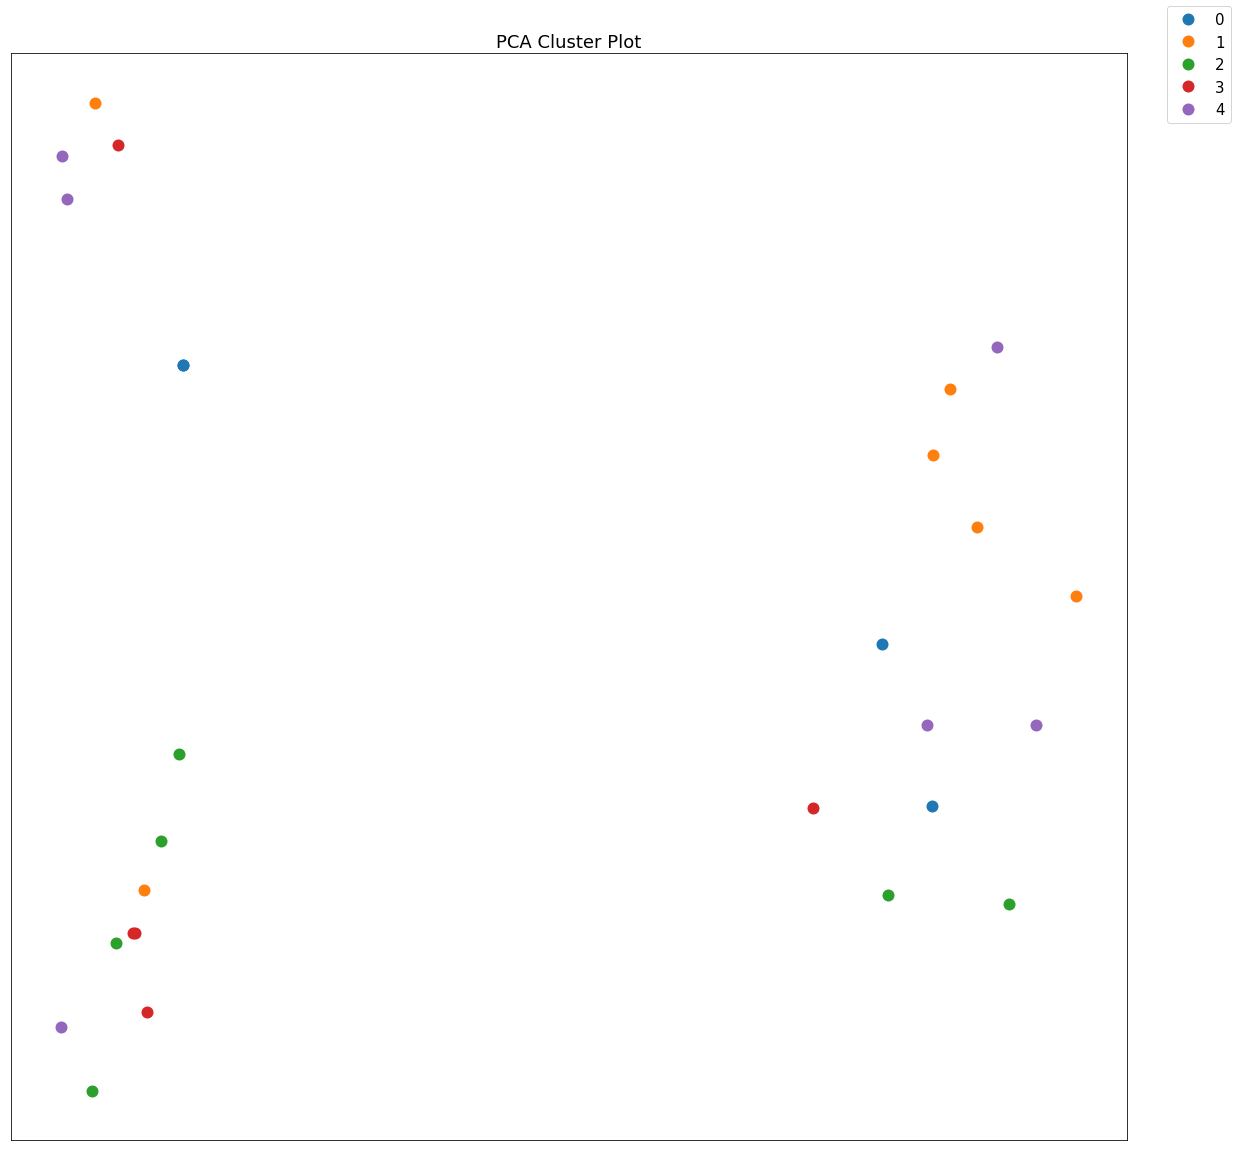

In [16]:
cluster_plot(X, 'PCA Cluster Plot', without_labels=True, savepath='/Users/yoo-jin/Desktop/pca_kmeans_spherical_2GB_mixedAM.png')



/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


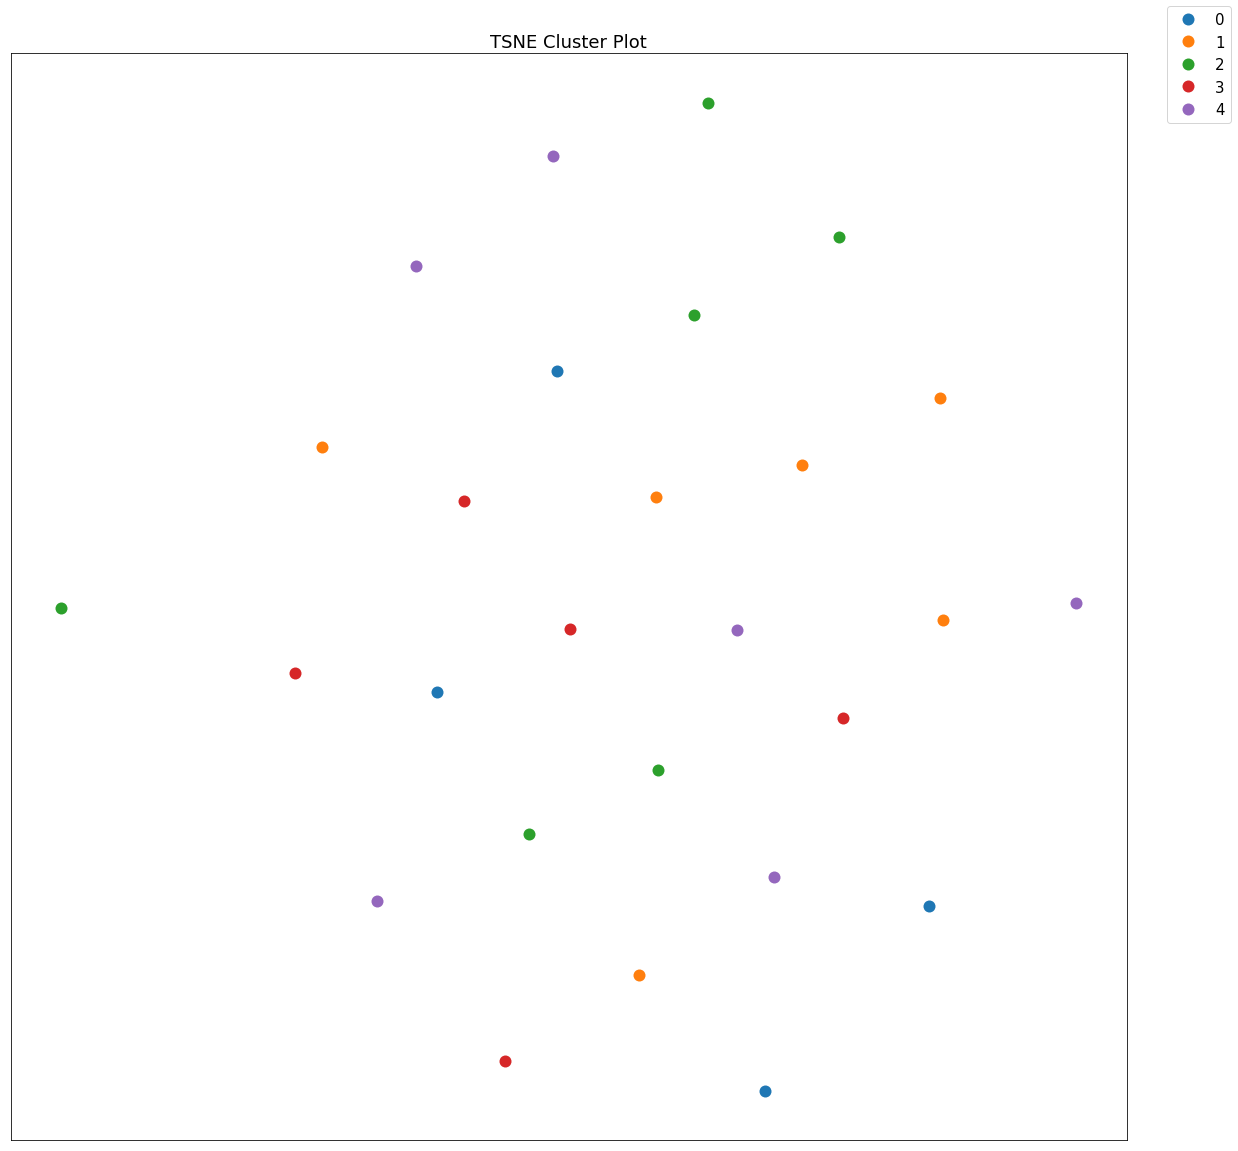

In [17]:
from sklearn.manifold import TSNE
dist = 1 - cosine_similarity(mfcc_clips)
mds = TSNE(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'TSNE Cluster Plot', without_labels=True)

# Cluster Interpretation
Play some clips in each of the clusters

In [18]:
# Returns all clip indexes within a cluster
def get_clip_indexes(cluster_label, clusters):
    clips_i = []
    for i in range(len(clusters)):
        if clusters[i] == cluster_label:
            clips_i.append(i)
    return clips_i

# Plays a random clip in a given cluster
def play_random_clip_in_cluster(index, clusters, option='cluster'):
    assert(option == 'cluster' or option == 'clip')
    if option == 'clip':
        index = find_cluster(index, clusters) # Get cluster index
    
    clips = get_clip_indexes(index, clusters)
    clip_i = clips[random.randint(0, len(clips) - 1)]
    print('Playing clip index %d ' % clip_i)
    play_clip(clip_i)
        
# Returns the cluster label that a clip belongs to
def find_cluster(clip_index, clusters):
    return clusters[clip_index]

# Plays an audio clip given the clip index
def play_clip(clip_index):
    samples = shorter_clips[clip_index]
    sd.play(samples, sample_rate)

# Flattens a given list
def list_flatten(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

# Saves clip as a wav file
def save_clip(filename, wav_array):
#     assert('.' not in filename)
    write(filename + '.wav', 44100, wav_array)
    
# Saves all clips to a directory
def save_clips_to_dir(shorter_clips, dirname):
    for i, clip in enumerate(shorter_clips):
        save_clip(dirname + '/%d' % i, clip) 

In [19]:
# Prints: (Cluster number, count of clips in cluster)
from collections import Counter
import random
import sounddevice as sd

Counter(clusters).most_common()

[(4, 6), (1, 6), (2, 6), (3, 5), (0, 4)]

In [20]:
sample_rate = 44100
play_random_clip_in_cluster(0, clusters) # Play random clip in a cluster

Playing clip index 1 


In [21]:
sd.stop() # Stop playing

In [22]:
play_clip(10)

In [23]:
sd.stop() # Stop playing

## Save clusters of audio files
Go through the list of filenames and extract the bird species present in the xeno canto data. Also, print out the clusters that each file is put into. 

In [24]:
num_bird_species = []
cluster_list_ordered = []

for i in range(len(np.unique(clusters))): 
    cluster_set = set()
    for j in get_clip_indexes(i, clusters):
        cluster_list_ordered.append(i)
        bird_species = os.path.splitext(file_names[j])[0].split("-",1)[1].strip()
        cluster_set.add(bird_species)
    num_bird_species.append(len(cluster_set))

print(file_names)
print(cluster_list_ordered)
print(cluster_set)
# print(num_bird_species)   

['XC22269 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3', 'XC22270 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3', 'XC23428 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', 'XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3', "XC40313 - Goeldi's Antbird - Akletos goeldii.mp3", "XC

## Evaluation Metrics

### Silhouette Analysis 
Silhoutte analysis on the different clusters. Note that 

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : -4.561784663802529e-18
For n_clusters = 3 The average silhouette_score is : -8.66739086122481e-17


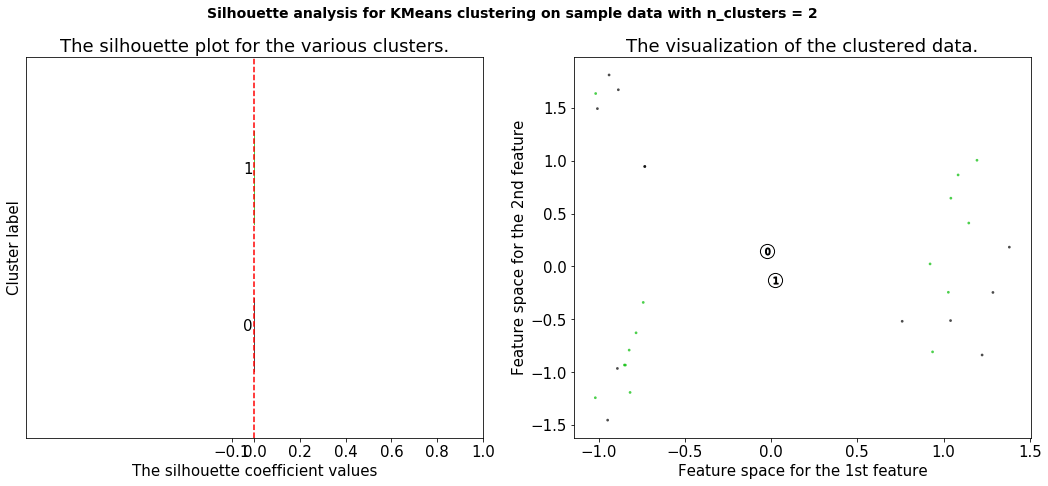

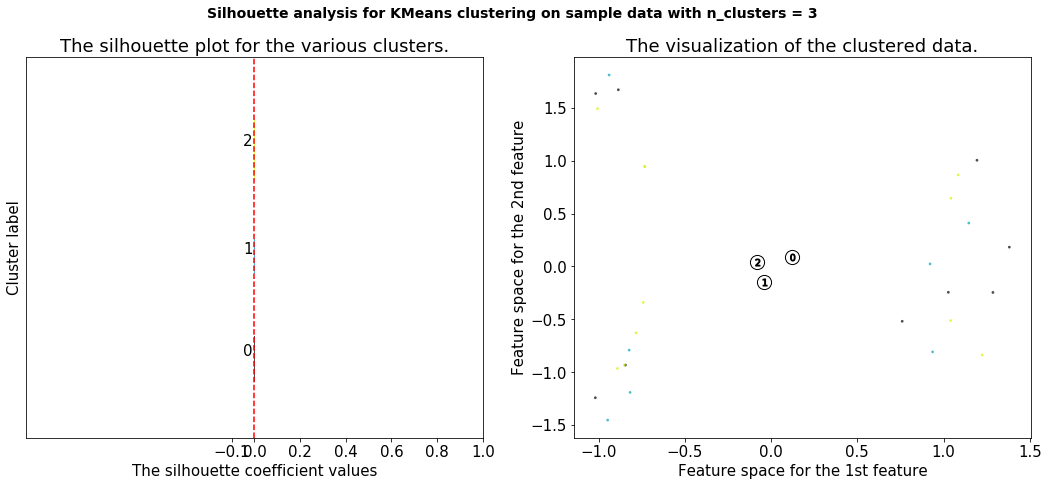

In [25]:
# Need to do on a much larger dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = range(2,4) 

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    clusterer = SphericalKMeans(n_clusters, random_state=10).fit(X)
    cluster_labels = clusterer.fit_predict(X) #fits then predict, gives labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [26]:
## Silhouette score for each cluster

# https://stackoverflow.com/questions/59919627/how-to-calculate-the-silhouette-score-for-each-cluster-separately-in-python

# You could use metrics.silhouette_samples to compute 
# the silhouette coefficients for each sample, then 
# take the mean of each cluster:
n_clusters = 5
kmeans = MiniBatchKMeans(n_clusters, random_state=10).fit(X)
cluster_labels = kmeans.labels_
sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

means_lst = []
for label in range(n_clusters):
    means_lst.append(sample_silhouette_values[cluster_labels == label].mean())
    
print(means_lst)                                                                             

NameError: name 'MiniBatchKMeans' is not defined

In [27]:
# Reference:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from spherecluster import SphericalKMeans

## n_clusters defined above ##
n_clusters = 5
kmeans = SphericalKMeans(n_clusters).fit(X)


## Metrics to analyze the clusters 
Evaluating the clusters through different established metrics.

### Metrics that work for unlabelled data

#### Silhouette Value
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

According to this [article](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c), a score of 0 for the silhouette score means that the clusters are indifferent or the distance between clusters are not significant. Or in other words, the silhouette score indicates that the sample is on or very close to the decision boundary separating two neighboring clusters.

From this [article](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a), concludes that good n_clusters will have a silhouette average score of above 0.5. 

In [28]:
print("Silhouette score:", silhouette_score(X, kmeans.labels_))

Silhouette score: -6.386498529323544e-17


#### Davies Bouldin Score
The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.

The minimum score is zero, with lower values indicating better clustering. The higher the score the better the separation is.

In [30]:
print("Davies Bouldin Score:", davies_bouldin_score(X, kmeans.labels_))


Davies Bouldin Score: 3.186346068320347


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


### Metrics that work for labeled data

#### Adjusted Random Score 
The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

Similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.

In [31]:
# https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
# Bad (e.g. independent labelings) have non-positive scores:
print("Adjusted Random Score", metrics.adjusted_rand_score(true_labels, kmeans.labels_))

Adjusted Random Score 0.0613445573564635


#### Mutual Information Based Scores
Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations. Random (uniform) label assignments have a AMI score close to 0.0 for any value of n_clusters and n_samples(which is not the case for raw Mutual Information or the V-measure for instance).

[Source](https://esigma6.wordpress.com/2018/11/03/2-3-9-2-mutual-information-based-scores/)

In [32]:
print("Mutual Information based scores", metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_))

Mutual Information based scores 0.04475796334446643


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


#### Homogeneity 
Homogeneity metric of a cluster labeling given a ground truth. A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class. score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling

homogeneity: each cluster contains only members of a single class.

In [34]:
print("Homogeneity", metrics.homogeneity_score(true_labels, kmeans.labels_))

Homogeneity 0.288797974012245


#### Completeness
Completeness metric of a cluster labeling given a ground truth. 
A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

They are bounded below by 0.0 and above by 1.0

completeness: all members of a given class are assigned to the same cluster.

In [35]:
print("Completeness", metrics.completeness_score(true_labels, kmeans.labels_))

Completeness 0.26672797474297827


#### V-measure
Equation: 2 * (homogeneity * completeness) / (homogeneity + completeness)
Their harmonic mean called V-measure is computed by v_measure_score. 

For further [reference](https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure)

In [41]:
print("V-measure", metrics.v_measure_score(true_labels, kmeans.labels_))

V-measure 0.23183353604854004


#### Fowlkes Mallows Score
Measure the similarity of two clusterings of a set of points. The score ranges from 0 to 1. A high value indicates a good similarity between two clusters. If classes members are completely split across different clusters, the assignment is totally random, hence the FMI is null:

In [42]:
print("Fowlkes-Mallows score", metrics.fowlkes_mallows_score(true_labels, kmeans.labels_))

Fowlkes-Mallows score 0.2071989632307816


## Save as .csv

In [57]:
## pandas dataframe ## 
import pandas as pd 

full_data = {
    'File name': file_names,
    'Time in clip (seconds)': timestamp,
    'Cluster number': cluster_list_ordered
}

df = pd.DataFrame(full_data, columns = ['File name', 'Time in clip (seconds)', 'Cluster number'])

df.to_csv(r'/Users/yoo-jin/Desktop/073120_export_dataframe_kmeanspherical_xenocanto_downsampled.csv',index = False, header=True)
            
print(df.head())

             File name Time in clip (seconds)  Cluster number
0  20190610_022000.WAV                [0, 10]               0
1  20190610_022000.WAV               [10, 20]               0
2  20190610_022000.WAV               [20, 30]               0
3  20190610_022000.WAV               [30, 40]               0
4  20190610_022000.WAV               [40, 50]               0


# Optional (save clip)

In [ ]:
dirname = '/Volumes/Elements/Test/Clusters/'
# dirname = '/Volumes/Elements/Test/Clusters/'

for i in range(len(np.unique(clusters))):
    os.mkdir(dirname + 'cluster_%d' % i)
    for j in get_clip_indexes(i, clusters):
        save_clip(dirname + 'cluster_%d/%s' % (i, file_names[j]), final_d[j])

## Analyze clusters 
Find the total number of bird species in cluster and also the list of dictionary of each file name corresponding to each cluster number

In [55]:
num_bird_species = []
cluster_list_ordered = []

for i in range(len(np.unique(clusters))): 
    cluster_set = set()
    for j in get_clip_indexes(i, clusters):
        cluster_list_ordered.append(i)
        bird_species = os.path.splitext(file_names[j])[0].split("-",1)[1].strip()
#         print(bird_species)
#         print(type(bird_species))
        cluster_set.add(bird_species)
    num_bird_species.append(len(cluster_set))
    print(cluster_set)

print(file_names)
print(cluster_list_ordered)
# print(num_bird_species)        

{'White-winged Shrike-Tanager - Lanio versicolor', 'White-eyed Antwren - Epinecrophylla leucophthalma', 'White-crested Spadebill - Platyrinchus platyrhynchos', "Goeldi's Antbird - Akletos goeldii"}
{'White-winged Shrike-Tanager - Lanio versicolor', "Goeldi's Antbird - Akletos goeldii"}
{"Goeldi's Antbird - Akletos goeldii", 'Black Antbird - Cercomacroides serva'}
{"Goeldi's Antbird - Akletos goeldii", 'White-eyed Antwren - Epinecrophylla leucophthalma'}
{"Goeldi's Antbird - Akletos goeldii", 'Black Antbird - Cercomacroides serva', 'White-eyed Antwren - Epinecrophylla leucophthalma'}
['XC22269 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3', 'XC22270 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22404 - Black Antbird - Cercomacroides serva.mp3', 'XC22458 - White-eyed Antwren - Epinecrophylla leucop

5
Average number of birds over clusters: 2.6


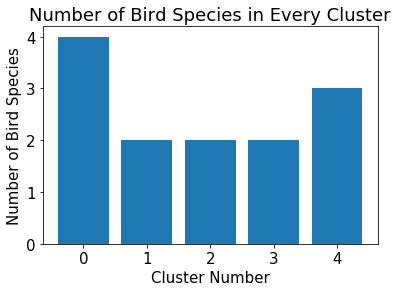

In [56]:
# Number of Bird Species in Every Cluster
print(len(num_bird_species))
cluster_num = range(0,len(num_bird_species))

x = cluster_num 
y = num_bird_species

# Add title, axes
plt.bar(x,y)
plt.title('Number of Bird Species in Every Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Bird Species')

average_num_birds = sum(num_bird_species)/len(num_bird_species)
print("Average number of birds over clusters:", average_num_birds)

# Visualization

### Optional: For K-means clustsering 
The function, find_optimal_clusters is used to find the optimal number of clusters for K-means clustering. Take a look at this link for more information: https://hlab.stanford.edu/brian/number_of_clusters_.html.

In [ ]:
# dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
dir_path = '/Volumes/Elements/Test/'
samplerate = None
wav_data = []
bird_names_and_lengths = []
num_files = 0

for file in glob.glob(os.path.join(dir_path, '*.mp3')):
#     print(file)
#     resample_mp3(file, overwrite=True)
    num_files = num_files+1
    try: 
        data, rate = resample_mp3(file, overwrite=True)
#         data = data.astype(int)
        samplerate = rate
        if wav_data == []:
            wav_data = data
        else:
            wav_data = np.concatenate((wav_data, data))
        clip_len = len(data) / samplerate
        
        # Input only bird species
        bird_species = file.split(' - ')[2][:-4].replace(' ', '_')
        bird_names_and_lengths.append([bird_species, clip_len])
#         print(file)
        
        # TO DO: deal with warning, don't suppress
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
        warnings.filterwarnings("ignore", category=FutureWarning) 
    except Exception as e:
        print('(failed) ' + file)
        print('\t' + str(e))
        pass
    
print(bird_names_and_lengths)
    
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()

### Optional: list all bird species included in the file

In [ ]:
dir_path = '/Volumes/Elements/Test/'
list_of_species = []

for f in glob.glob(os.path.join(dir_path, '*.mp3')): 
    bird_name = os.path.splitext(f)[0].split(" - ", 1)[1].strip()
    if list_of_species == []: 
        list_of_species = [bird_name]
    elif bird_name in list_of_species: 
        pass 
    else: 
        list_of_species.append(bird_name)

print(list_of_species)
# print(len(list_of_species))

In [ ]:
print("shape of wav_data", len(wav_data))
print("sample rate", sr)
print("type of wav_data", type(wav_data))
print('sample rate = %d' % samplerate)
print(wav_data.shape)
length = wav_data.shape[0] / samplerate
print('length = %.1fs' % length)

In [ ]:
# loop through all the cluster folders 
from os import listdir
from os.path import isfile, join

# dirname = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/'
dirname = '/Volumes/Elements/Test/Clusters/'
directory_list = os.listdir(dirname)
# print(directory_list)
# make "find . -name ".DS_Store" -delete" in the terminal 

final_bird_list = []
num_bird_species = []

for d in directory_list: 
    path = dirname + d
    file_list = [f for f in os.listdir(path) if not f.startswith('.')]
    
    cluster_set = set()
    for f in file_list: 
#         print(f)
#         if not f.startswith('.'):
        cluster_set = cluster_set | find_bird_species_from_file_name(f)
#         print(f)
    
    num_bird_species.append(len(cluster_set))
    final_bird_list.append(num_bird_species)
        
# print(final_bird_list)
# print(cluster_set)
print(num_bird_species)